In [23]:
import torch
from torch import Tensor
import torch.nn as nn
import torchvision
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import numpy as np 
from torch.utils.data import Dataset, DataLoader
import os 
from torchmetrics.classification.accuracy import BinaryAccuracy



In [24]:
import os 
import pandas as pd 

from torchvision.io import read_image, ImageReadMode
import torchvision.transforms as T


In [25]:
train_path = "MarioKart.v1i.tensorflow/train"
val_path = "MarioKart.v1i.tensorflow/valid"

In [26]:
train_annotations = pd.read_csv(f"{train_path}/_annotations.csv")
val_annotations = pd.read_csv(f"{val_path}/_annotations.csv") 
val_annotations.head() 

,filename,width,height,class,xmin,ymin,xmax,ymax
0,captured2_7_png.rf.8475baa53adc8aca775060bc8cf...,640,640,Border,0,67,231,362
1,captured2_7_png.rf.8475baa53adc8aca775060bc8cf...,640,640,Border,384,62,640,426
2,captured2_7_png.rf.8475baa53adc8aca775060bc8cf...,640,640,Player,215,210,272,319
3,captured2_7_png.rf.8475baa53adc8aca775060bc8cf...,640,640,Player,302,163,374,262
4,captured2_7_png.rf.8475baa53adc8aca775060bc8cf...,640,640,Player,283,79,321,151


In [27]:
tensor_images = {}

for path in set(train_annotations['filename']):
    img = read_image(f"{train_path}/{path}", ImageReadMode.RGB)
    tensor_images[path] = img 


In [28]:
#Mappings of classes - uniform throughout anytime this is called 
class_mappings = {} 
class_idx = 0 

class CustomDataLoader(Dataset):
    def __init__(self, df):
        self.annotations = df 
    def __len__(self):
        return len(self.annotations.index) 
    
    def __getitem__(self, idx):
        row = self.annotations.iloc[idx]
        return row['filename'], row['xmin'], row['ymin'], row['xmax'], row['ymax'], row['class']  

class AggregatedDataLoader(Dataset):
    def __init__(self, images, targets):
        self.images = images 
        self.targets = targets 
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        return self.images[idx], self.targets[idx] 
    
def generate_images_tensors_dataloader(df, path_modifier):
    """
        Provided a DataFrame of Annotations, creates the corresponding tensor object holding the boxes / classes, 
        the list of images as tensors, and a DataLoader object, if necessary 
    """
    global class_idx 
    tensor_images = {} 
    for path in set(df['filename']):
        img = read_image(f"{path_modifier}/{path}", ImageReadMode.RGB)
        tensor_images[path] = img 
    
    DLObj = CustomDataLoader(df) 
    
    aggregated_images = {} 
    for row in DLObj:
        train_idx = row[0] 
        position = torch.Tensor(row[1:5])
        class_name = row[5]  
        
        if not class_name in class_mappings:
            class_mappings[class_name] = class_idx 
            class_idx += 1 
        class_name = class_mappings[class_name] 
        
        if train_idx in aggregated_images:
            aggregated_images[train_idx]['boxes'].append(position)
            aggregated_images[train_idx]['labels'].append(class_name)
        else:
            aggregated_images[train_idx] = {'boxes':[position], 'labels':[class_name]}
    # Normalization and float converter objects 
    norm = T.Normalize(0.5, 1)  
    floatConv = T.ConvertImageDtype(torch.float32)
        
    images, targets = [], [] 
    
    for key in aggregated_images:
        # Add image tensor, converted to float 
        img = tensor_images[key] 
        img = floatConv.forward(img) 
        images.append(img) 
        
        boxes = aggregated_images[key]['boxes'] 
        torch_box = torch.stack(boxes)  
        torch_labels = torch.tensor(aggregated_images[key]['labels'])
        targets.append(
            {'boxes':torch_box, 
             'labels':torch_labels
            }
        )
    return images, targets, DLObj 
    


In [29]:
# Will display a corresponding image and bounding boxes / predictions made for it 
from torchvision.utils import draw_bounding_boxes
import torchvision.transforms.functional as F


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

uintTransform = T.ConvertImageDtype(torch.uint8)

def renderPredictions(img, preds):        
    colors = ["blue"] * len(preds['boxes']) 
    result = draw_bounding_boxes(uintTransform.forward(img), preds['boxes'], colors=colors, width=5)
    show(result)

## Fast R-CNN: 


In [35]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights


In [30]:
class MarioFastRCNN(pl.LightningModule):
    
    def __init__(self, model):
        super().__init__()
        
        self.model = model  
    
    def training_step(self, batch, batch_idx):
        train_image, train_tensor = batch 
        loss = self.model([train_image], [train_tensor]) 
        
        
        loss = sum(loss for loss in loss.values())
        return loss 
                
    
    def validation_step(self, batch, batch_idx):
        
        image, tensor = batch 
        
        preds = self.model([image]) 
        
        return preds, tensor 
    
    def forward(self, x):
        self.model.eval()
        return self.model(x) 
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer  
 

In [32]:
# Loading training data objects we will be interacting with 
train_images, train_targets, train_dlobj = generate_images_tensors_dataloader(train_annotations, train_path) 
val_images, val_targets, val_dlobj = generate_images_tensors_dataloader(val_annotations, val_path) 

train_dlobj = AggregatedDataLoader(train_images, train_targets)
val_dlobj = AggregatedDataLoader(val_images, val_targets) 

In [33]:
#fast_rcnn = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT) 

pl.seed_everything(42, workers=True)

trainer = pl.Trainer(max_epochs=10,
                     logger=pl.loggers.TensorBoardLogger('./voc'),
                     log_every_n_steps=1) 
fast_rcnn = torchvision.models.detection.fasterrcnn_resnet50_fpn(pre_trained=True,num_classes=len(class_mappings)) 
model = MarioFastRCNN(fast_rcnn) 
trainer.fit(model=model, train_dataloaders=train_dlobj, val_dataloaders=val_dlobj) 


Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params
-------------------------------------
0 | model | FasterRCNN | 41.3 M
-------------------------------------
41.1 M    Trainable params
222 K     Non-trainable params
41.3 M    Total params
165.217   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/Users/ryankennedy/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/call.py:54: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [ ]:
print(len())

In [36]:
# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pre_trained=True,num_classes=len(class_mappings), weights=weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT) 
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT) 

output = model(train_images, train_targets) 


In [37]:
model.eval() 
print("Done") 

Done


In [38]:
predictions = model(val_images) 


{'Player': 0, 'Border': 1, 'Pipe': 2}


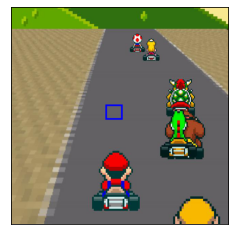

In [39]:
# print(predictions)
print(class_mappings)
renderPredictions(train_images[0], predictions[0]) 

In [3]:
TRAIN_SEGMENTATION = "SegmentationMaps/train"
VAL_SEGMENTATION = "SegmentationMaps/val"

In [19]:
seg_df = pd.read_csv(f"{TRAIN_SEGMENTATION}/_classes.csv")
seg_df.head() 

pixel_maps = {} 
for i in seg_df.T:
    row = seg_df.loc[i] 
    val = row['Pixel Value'] 
    cl = row[' Class'] 
    pixel_maps[cl] = val 
print(pixel_maps)     

{' background': 0, ' Road': 1}


In [20]:
class SegDL(Dataset):
    def __init__(self, lof_mappings):
        self.lof_mappings = lof_mappings 
    def __len__(self):
        return len(self.lof_mappings) 
    
    def __getitem__(self, idx):
        pair = self.lof_mappings[idx] 
        return pair 
    
def create_segmentation_dl_obj(PATH):
    lof_images = [] 
    for file in os.listdir(TRAIN_SEGMENTATION):
        if '.csv' not in file and '_mask' not in file:
            mask_file = file.replace(".jpg", "") 
            mask_file = f"{mask_file}_mask.png" 

            img = read_image(f"{TRAIN_SEGMENTATION}/{file}")
            m_img = read_image(f"{TRAIN_SEGMENTATION}/{mask_file}", ImageReadMode.RGB)
            lof_images.append((img, m_img))
    return SegDL(lof_images)  


In [132]:
# # sem_class_to_idx = {cls: idx for (idx, cls) in enumerate(pixel_maps)}

# first_image = t_seg_images[avail_images[0]][1] 

# first_image = first_image[None,:,:,:] 

# print(first_image.shape) 

# # Idk figure out some way to render this map? 

torch.Size([1, 3, 640, 640])


In [6]:
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights
weights=FCN_ResNet50_Weights.DEFAULT
model = fcn_resnet50(weights=weights, progress=False)
# model = model.eval()
transforms = weights.transforms(resize_size=None) 


In [17]:

class MarioSegmentation(pl.LightningModule):
    
    def __init__(self):
        super().__init__()

        self.acc_metric = BinaryAccuracy()
        self.criterion = nn.BCELoss()
        
        self.first_downsample = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=1),  
            nn.BatchNorm2d(32), 
            nn.ReLU(True) , 
        )

        self.second_downsample = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1),  
            nn.BatchNorm2d(64), 
            nn.ReLU(True)  
        )

        self.third_downsample = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),  
            nn.BatchNorm2d(128), 
            nn.ReLU(True) , 
        )


        self.first_upsample = nn.Sequential(
          nn.ConvTranspose2d(in_channels=128, out_channels=64,  kernel_size=3, stride=2, padding=1, output_padding=1), 
          nn.BatchNorm2d(64), 
          nn.ReLU(True) , 
        )

        self.second_upsample = nn.Sequential(
          nn.ConvTranspose2d(in_channels=64, out_channels=32,  kernel_size=3, stride=2, padding=1, output_padding=1), 
          nn.BatchNorm2d(32), 
          nn.ReLU(True) , 
        )

        self.third_upsample =  nn.Sequential( 
          nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, padding=1, output_padding=1), 
          nn.BatchNorm2d(16), 
          nn.ReLU(True) , 
        )
        # Using sigmoid at the end instead of batchNorm / Relu at this part 
        self.final_layer = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=1, kernel_size=1),  
        )
         
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer 
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y[y==255] = 0
        y[y>0] = 1
        y_pred = self(x)
        loss = self.criterion(y_pred, y.float())
        self.log("train_loss", loss)
        acc = self.acc_metric(y_pred, y)
        self.log("train_acc", acc, prog_bar=True)
        return loss     
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y[y==255] = 0
        y[y>0] = 1
        y_pred = self(x)
        loss = self.criterion(y_pred, y.float())
        self.log("train_loss", loss)
        acc = self.acc_metric(y_pred, y)
        self.log("train_acc", acc, prog_bar=True)
        return loss
 
    def forward(self, x):
        first_downsample = self.first_downsample(x) 
        second_downsample = self.second_downsample(first_downsample) 

        third_downsample = self.third_downsample(second_downsample) 


        first_upsample = self.first_upsample(third_downsample)

        merge = first_upsample  + second_downsample 

        second_upsample = self.second_upsample(merge) 

        merge = second_upsample + first_downsample 
        third_upsample = self.third_upsample(merge) 
        result = self.final_layer(third_upsample) 

        return nn.Sigmoid()(result)   


# Creating dataloader objects for these! 
seg_training_dl = create_segmentation_dl_obj(TRAIN_SEGMENTATION)
seg_val_dl = create_segmentation_dl_obj(VAL_SEGMENTATION)
model = MarioSegmentation() 

In [18]:
trainer = pl.Trainer(max_epochs=10,
                     logger=pl.loggers.TensorBoardLogger('./voc'),
                     log_every_n_steps=1) 
trainer.fit(model=model, train_dataloaders=seg_training_dl, val_dataloaders=seg_val_dl) 


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type           | Params
-----------------------------------------------------
0 | acc_metric        | BinaryAccuracy | 0     
1 | criterion         | BCELoss        | 0     
2 | first_downsample  | Sequential     | 960   
3 | second_downsample | Sequential     | 18.6 K
4 | third_downsample  | Sequential     | 74.1 K
5 | first_upsample    | Sequential     | 73.9 K
6 | second_upsample   | Sequential     | 18.5 K
7 | third_upsample    | Sequential     | 4.7 K 
8 | final_layer       | Sequential     | 17    
-----------------------------------------------------
190 K     Trainable params
0         Non-trainable params
190 K     Total params
0.763     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

RuntimeError: Input type (unsigned char) and bias type (float) should be the same

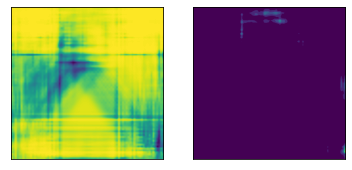

In [145]:
normalized_masks = torch.nn.functional.softmax(output, dim=1)

dog_and_boat_masks = [
    normalized_masks[0, pixel_maps[cls]]
    for cls in (' background', ' Road')
]

show(dog_and_boat_masks)